# ДЗ №5

Задание из 2-х частей.
Берем отызывы за лето (из архива с материалами или предыдущего занятия)

### Загрузка данных

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
# nltk.download("punkt")

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.objectives import categorical_crossentropy
from keras.callbacks import EarlyStopping  

In [13]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

def getVocabulary(corpus):
    tokens = word_tokenize(corpus.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]

    dist = FreqDist(tokens_filtered)
    tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

    return {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [15]:
data = pd.read_csv("отзывы за лето.csv", sep=';')
data = data[data['Rating'] != 3]
data['Content'] = data['Content'].apply(preprocess_text)
data['Rating'] = data['Rating'] > 3
data['Rating'] = data['Rating'].astype(int)

In [18]:
max_len = 100
max_words = 2000
num_classes = 2

In [19]:
train, test = train_test_split(data,  random_state=42, test_size=0.2)
train, val  = train_test_split(train, random_state=42, test_size=0.2)

vocabulary = getVocabulary(" ".join(train["Content"]))

def getX(df):
    return np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df["Content"]], dtype=np.int32)

x_train = getX(train)
x_test = getX(test)
x_val = getX(val)

In [20]:
x_train.shape, x_test.shape, x_val.shape

((12638, 100), (3950, 100), (3160, 100))

### 1. Учим conv сеть для классификации - выбить auc выше 0.95

In [21]:
y_train = keras.utils.to_categorical(train["Rating"], num_classes)
y_val = keras.utils.to_categorical(val["Rating"], num_classes)
y_test = keras.utils.to_categorical(test["Rating"], num_classes)

In [36]:
nn = 128
epochs = 30
batch_size = 128


model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=nn, input_length=max_len))

model.add(Conv1D(nn, 3))
model.add(Activation("relu"))

model.add(Conv1D(nn, 3))
model.add(Activation("relu"))

model.add(Conv1D(nn, 3))
model.add(Activation("relu"))

model.add(GlobalMaxPool1D())

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 128)          256000    
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 98, 128)           49280     
_________________________________________________________________
activation_25 (Activation)   (None, 98, 128)           0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 96, 128)           49280     
_________________________________________________________________
activation_26 (Activation)   (None, 96, 128)           0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 94, 128)           49280     
_________________________________________________________________
activation_27 (Activation)   (None, 94, 128)          

In [37]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.AUC(name='auc')])

early_stopping=EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, 
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

/Users/xander/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 12638 samples, validate on 3160 samples
Epoch 1/30
12638/12638 [==============================] - 29s 2ms/step - loss: 0.3000 - auc: 0.9451 - val_loss: 0.1991 - val_auc: 0.9761
Epoch 2/30
12638/12638 [==============================] - 29s 2ms/step - loss: 0.1654 - auc: 0.9834 - val_loss: 0.1862 - val_auc: 0.9790
Epoch 3/30
12638/12638 [==============================] - 30s 2ms/step - loss: 0.1293 - auc: 0.9895 - val_loss: 0.2003 - val_auc: 0.9764
Epoch 4/30
12638/12638 [==============================] - 28s 2ms/step - loss: 0.1017 - auc: 0.9931 - val_loss: 0.2235 - val_auc: 0.9738


In [38]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

3950/3950 [==============================] - 2s 578us/step
Test score: 0.22148458495924744
Test accuracy: 0.9735473990440369


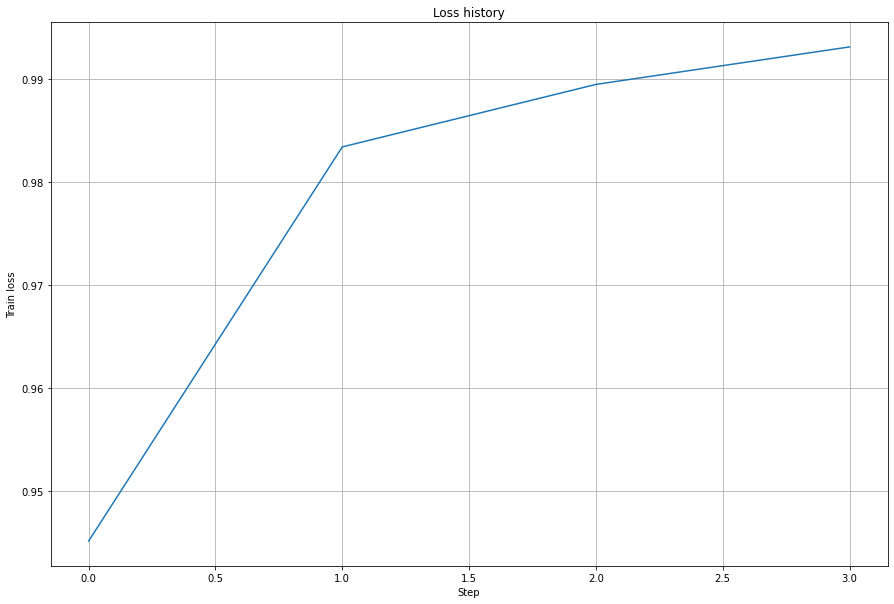

In [39]:
plt.figure(figsize=(15,10))
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(history.history['auc']);
plt.show()

### 2. Предобучаем word2vec и его эмбединга инициализируем сетку, как влияет на качество?

In [43]:
import gensim 
from gensim.models import Word2Vec

In [42]:
words = train.Content.apply(lambda x: x.split())
w2v = gensim.models.Word2Vec(words, min_count = 1, size = max_len, window = 5)

In [75]:
def vec(x):
    words = x.split()
    vec = np.zeros((max_len,))
    cnt = 0
    for i in x:
        if i in w2v.wv:
            vec += w2v.wv[i]
            cnt += 1
    return vec / cnt if cnt>0 else vec

In [78]:
def getWX(df):
    return np.asarray([vec(text) for text in df["Content"]], dtype=float)

x_train = getX(train)
x_test = getX(test)
x_val = getX(val)

In [79]:
y_train = keras.utils.to_categorical(train["Rating"], num_classes)
y_val = keras.utils.to_categorical(val["Rating"], num_classes)
y_test = keras.utils.to_categorical(test["Rating"], num_classes)

In [80]:
nn = 128
epochs = 30
batch_size = 128


model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=nn, input_length=max_len))

model.add(Conv1D(nn, 3))
model.add(Activation("relu"))

model.add(Conv1D(nn, 3))
model.add(Activation("relu"))

model.add(Conv1D(nn, 3))
model.add(Activation("relu"))

model.add(GlobalMaxPool1D())

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 128)          256000    
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 98, 128)           49280     
_________________________________________________________________
activation_29 (Activation)   (None, 98, 128)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 96, 128)           49280     
_________________________________________________________________
activation_30 (Activation)   (None, 96, 128)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 94, 128)           49280     
_________________________________________________________________
activation_31 (Activation)   (None, 94, 128)          

In [81]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.AUC(name='auc')])

early_stopping=EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, 
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

/Users/xander/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 12638 samples, validate on 3160 samples
Epoch 1/30
12638/12638 [==============================] - 32s 3ms/step - loss: 0.3133 - auc: 0.9402 - val_loss: 0.2085 - val_auc: 0.9757
Epoch 2/30
12638/12638 [==============================] - 30s 2ms/step - loss: 0.1700 - auc: 0.9825 - val_loss: 0.1904 - val_auc: 0.9791
Epoch 3/30
12638/12638 [==============================] - 30s 2ms/step - loss: 0.1323 - auc: 0.9892 - val_loss: 0.1974 - val_auc: 0.9783
Epoch 4/30
12638/12638 [==============================] - 30s 2ms/step - loss: 0.1060 - auc: 0.9926 - val_loss: 0.2202 - val_auc: 0.9757


In [82]:
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

3950/3950 [==============================] - 2s 610us/step
Test score: 0.21841178211984755
Test accuracy: 0.9748163819313049


> **Вывод: возможно мне показалось но word2vec вариант работает немного лучше по качеству**